# Machine Learning Project
**Siddh Shah, Francis Yeh, Surain Saigal, Nathan Ma**

Predicting whether packages are delivered late or not based on delivery data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
%matplotlib inline

# Data Preparation
We will now load in the dataset from the CSV file. The data contains no missing values for any columns so no imputation or data cleanup is needed. We will look for anomalous rows later.

In [4]:
# First, get the data from the CSV file
df = pd.read_csv("dataset.csv")

# Drop the ID column
df = df.drop(df.columns[0], axis=1)

df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


# Data Exploration and Visualization

We are trying to predict the value of Reached.on.Time_Y.N based on the other features. In other words, we want to build a binary classification model that is trying to classify whether a certain package reached it's destination on time.

In [6]:
features = df.drop(["Reached.on.Time_Y.N"], axis=1)
labels = df["Reached.on.Time_Y.N"]
features.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,D,Flight,4,2,177,3,low,F,44,1233
1,F,Flight,4,5,216,2,low,M,59,3088
2,A,Flight,2,2,183,4,low,M,48,3374
3,B,Flight,3,3,176,4,medium,M,10,1177
4,C,Flight,2,2,184,3,medium,F,46,2484


Using our domain knowledge, we were unsure if Gender is an important feature in predicting whether the product was delivered on time. We will take a closer look using a bar chart and a chi-square test of statistical significance.

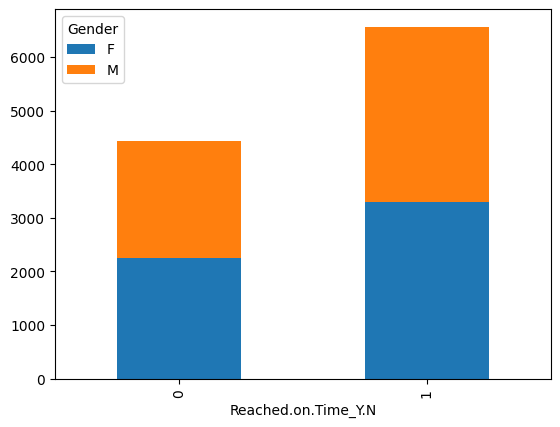

Chi-squared statistic: [0.86654644 0.12814262]
p-value: [0.35191318 0.72036566]


In [7]:
from scipy.stats import chisquare

gender_vs_time = df.groupby(['Gender', 'Reached.on.Time_Y.N']).size().unstack().T


gender_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

#probably drop gender, roughly equal

tab = pd.crosstab(df['Gender'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

The chi-square values and p-values between the two variables (gender and reached on time y/n) are relatively high. This indicated that there is no significant relationship between 'Gender' and 'Reached.on.Time_Y.N'. This conclusion is also supported by the visualization, which shows that the genders of the buyers of the packages is about evenly split whether the package reached on time or not. We have decided to drop the 'Gender' feature when we train our models.

We were also unsure about the importance of the Warehouse_block feature, so we decided to check it's statistical significance as well.

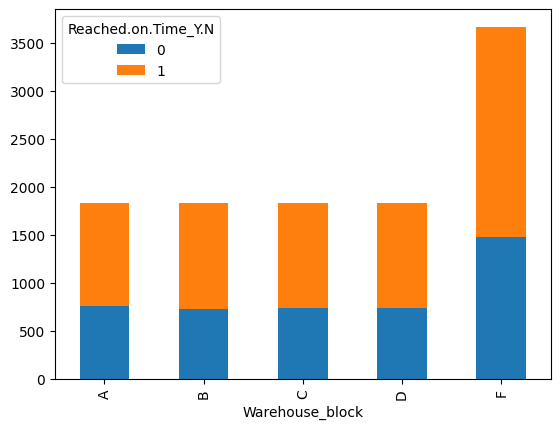

Chi-squared statistic: [482.34310189 740.16090203]
p-value: [4.41214072e-103 7.00761672e-159]


In [8]:
ware_vs_time = df.groupby(['Reached.on.Time_Y.N', 'Warehouse_block']).size().unstack().T


ware_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Warehouse_block'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

We found that the p-value between the warehouse block and the time reached on time is extremely low, and less than 0.05, so we can reject the null hypothesis that the warehouse block and the time reached on time are independent. The two are statistically dependent, so we can keep the warehouse block feature in our model. This is also supported by the bar chart above, where one can tell visually the warehouse block slightly affects the proportion of packages that are delivered on time.

Next, we decided to test if mode of shipment was statistically significant in relation to whether the packages reached on time.

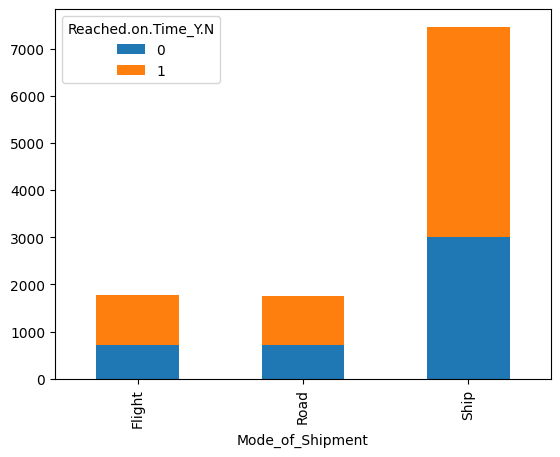

Chi-squared statistic: [2357.21325518 3537.56391894]
p-value: [0. 0.]


In [14]:
mode_vs_time = df.groupby(['Reached.on.Time_Y.N', 'Mode_of_Shipment']).size().unstack().T


mode_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Mode_of_Shipment'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

We found that the p-value between the mode of shipment and whether the packaged reached on time is extremely low (so much so that they print out as just "0"), and less than 0.05, so we can reject the null hypothesis that the mode of shipment and the time reached on time are independent. The two are statistically dependent, so we can keep the mode of shioment feature in our model. This is also somewhat supported by the bar chart above, where one can tell visually the mode of shipment slightly affects the proportion of packages that are delivered on time. The proportion of results for each mode of shipment is not the only factor that determines the p-value, however, so we can still be confident that the two variables are statistically related.

We also decided to test product_importance for statistical significance.

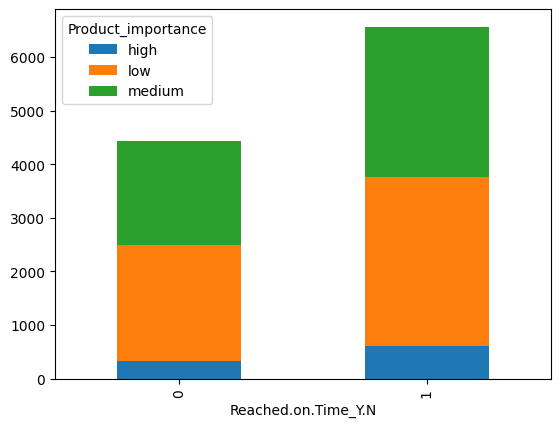

Chi-squared statistic: [1348.72633003 1719.02270303]
p-value: [1.34214252e-293 0.00000000e+000]


In [11]:
importance_vs_time = df.groupby(['Product_importance', 'Reached.on.Time_Y.N']).size().unstack().T
importance_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Product_importance'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

The results of this chi-square test and the visualization above show that the two variables are highly correlated, so we will keep product_importance when training our models.

Now we will test the statistical significance of some of the numerical features of our dataset. We will use the point-biserial correlation coefficient to determine statistical signficance, since that measure is better suited when relating a continous variable to a binary variable that the standard Pearson correlation coefficient (r).

In [20]:
from scipy.stats import pointbiserialr

# Calculate the point-biserial correlation coefficient
corr, p_value = pointbiserialr(df['Customer_rating'], df['Reached.on.Time_Y.N'])

print("Customer rating Point-biserial correlation coefficient:", corr)
print("Customer rating p-value:", p_value)
print()

corr, p_value = pointbiserialr(df['Customer_care_calls'], df['Reached.on.Time_Y.N'])

print("Customer care calls Point-biserial correlation coefficient:", corr)
print("Customer care calls p-value:", p_value)
print()

corr, p_value = pointbiserialr(df['Prior_purchases'], df['Reached.on.Time_Y.N'])
print("Prior purchases Point-biserial correlation coefficient:", corr)
print("Prior purchases p-value:", p_value)
print()

corr, p_value = pointbiserialr(df['Weight_in_gms'], df['Reached.on.Time_Y.N'])
print("Weight in grams Point-biserial correlation coefficient:", corr)
print("Weight in grams p-value:", p_value)
print()

corr, p_value = pointbiserialr(df['Discount_offered'], df['Reached.on.Time_Y.N'])
print("Discount offered Point-biserial correlation coefficient:", corr)
print("Discount offered p-value:", p_value)
print()




Customer rating Point-biserial correlation coefficient: 0.013118604264753572
Customer rating p-value: 0.1689048972253054

Customer care calls Point-biserial correlation coefficient: -0.06712585571198337
Customer care calls p-value: 1.827535178623936e-12

Prior purchases Point-biserial correlation coefficient: -0.05551501121359642
Prior purchases p-value: 5.676140483966826e-09

Weight in grams Point-biserial correlation coefficient: -0.2687925839387988
Weight in grams p-value: 2.3546582802917458e-181

Discount offered Point-biserial correlation coefficient: 0.39710847358321655
Discount offered p-value: 0.0



The output above displays the correlation coefficients and p-values for each continuous feature of the dataset in relation to whether the package was delivered on time or not. We can clearly see a stark difference between the values for customer rating, customer care calls, and prior purchases and the alues for weight in grams and discount offered. The first 3 features have correlations that are very close to 0, indicating weak correlation, and though they have small p-values, they are very large compared to the p0values for weight and discount offered. Weight in grams and discount offered both have significantly stronger correlations, and extremely small p-values. 

We decided that we will keep weight in grams and discount offered, but drop the other 3 continous features.

# Feature Selection and Engineering
Based on the data visualizations and tests of statistical signifiance above, we decided to drop the Gender, Customer rating, Customer care calls, and prior purchases columns as they didn't have high statistical significance when related to Reached.on.Time_Y.N (our class label).

In [8]:
#Dropping Gender, Customer Rating, Customer_care_calls, Prior Purchases
df = df.drop(["Gender", "Customer_rating", "Customer_care_calls", "Prior_purchases"], axis=1)
df.head()

,Warehouse_block,Mode_of_Shipment,Cost_of_the_Product,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,177,low,44,1233,1
1,F,Flight,216,low,59,3088,1
2,A,Flight,183,low,48,3374,1
3,B,Flight,176,medium,10,1177,1
4,C,Flight,184,medium,46,2484,1


We need to split the data into features and labels. We decided to label-encode the categorical features, rather than one-hot encode, to avoid the curse of dimensionality that could arise from adding more columns.

Most models require the all features to be numeric. This means we need to convert categorical features to numeric ones. Because of this, we need a converter. "LabelEncoder" will convert categorical labels into a numerical format. Each unique category in a column is assigned a numerical id. This process is applied to all columns that are of object type (typically strings or categories). This is a crucial step because it turns the data into a suitable format for training ML models.

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

features = df.drop(["Reached.on.Time_Y.N"], axis=1)
labels = df["Reached.on.Time_Y.N"]

features.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,3,0,4,2,177,3,1,0,44,1233
1,4,0,4,5,216,2,1,1,59,3088
2,0,0,2,2,183,4,1,1,48,3374
3,1,0,3,3,176,4,2,1,10,1177
4,2,0,2,2,184,3,2,0,46,2484


It should be noted that some of the models we will try out require scaling or dimensionality reductions of the features before training. This is technically part of feature engineering, but we will complete this step later on in this notebook as part of the pipelines to train the models.

# Anomaly Detection

Anamoly Detection is used to eliminate "anamolies" in the records in hopes to present the best training set and increase the accuracy. 

In [23]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), random_state=42)
pred = clf.fit_predict(df[['Cost_of_the_Product', 'Weight_in_gms']])
df['anomaly'] = pred
outliers = df[df['anomaly'] == -1]

print("Number of Anomaly Rows: ", len(outliers))

Number of Anomaly Rows:  110


Since our dataset is very large (11000 rows), losing 110 of them will likely not have a huge impact on performance. However, we will still drop the rows since they likely reflect errors in the real world data and could be adding unneccessary noise and bias to our models. 

In [24]:
# Drop anomalous rows

anomaly_indices = df[df['anomaly'] == -1].index
df = df.drop(anomaly_indices)

features = df.drop(["Reached.on.Time_Y.N", "anomaly"], axis=1)
labels = df["Reached.on.Time_Y.N"]

print("Number of Rows after dropping anomalies: ", len(df))

Number of Rows after dropping anomalies:  10889


# Training the Models
After cleaning, exploring, and engineering our data, our group decided that we would train 4 different models (KNN, SVM, Neural Network, Naive Bayes) to see which would perform best on our dataset. If all come out with relatively good accuracies, the plan is to heterogeneously ensemble them to achieve an even higher performance.

# KNN Model

A KNN is a simple model but might provide good results for our binary classification problem.

In [28]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

KNN Mean Accuracy:  0.65286068509505
KNN Classification Report: 
               precision    recall  f1-score   support

           0       0.55      0.72      0.63      4405
           1       0.76      0.61      0.68      6484

    accuracy                           0.65     10889
   macro avg       0.66      0.66      0.65     10889
weighted avg       0.68      0.65      0.66     10889



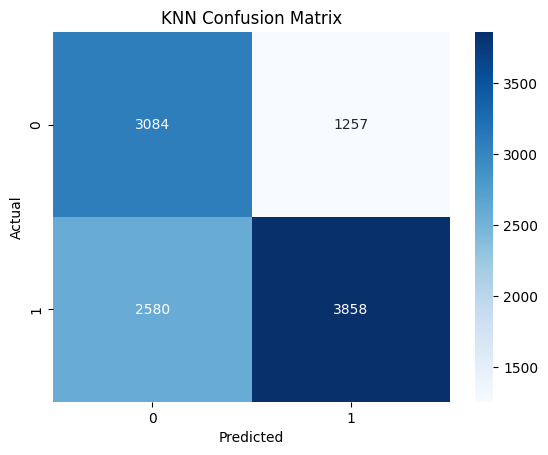

In [14]:

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])


# Define the parameters to test w/ nested CV
param_grid = {'knn__n_neighbors': [2, 3, 5, 7, 9, 12], 'knn__weights': ['uniform', 'distance'], 'pca': [None, PCA(n_components=0.8), PCA(n_components=0.85), PCA(n_components=0.9), PCA(n_components=0.95)]}

# Both CV folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True)

# Get nested CV score
grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy')
predictions = cross_val_predict(grid_search, features, labels, cv=outer_cv)

accuracy = accuracy_score(labels, predictions)
print("KNN Mean Accuracy: ", accuracy)

print("KNN Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()


The KNN's accuracy is higher than we thought it would be and has a similar f1-score. The confusion matrix shows that the model had the biggest issue with false negatives. It has a good precision but lower recall. 

In [15]:
from sklearn.metrics import accuracy_score
#60% isn't that great... but that's okay
grid_search.fit(features, labels)

# Obtain the best estimator (final model) from the grid search object
best_model = grid_search.best_estimator_

label_pred = best_model.predict(features)

accuracy = accuracy_score(labels, label_pred)

print("Accuracy on the entire dataset:", accuracy)

Accuracy on the entire dataset: 0.719441638350629


In [16]:
best_params = grid_search.best_params_
print(best_params) # we need to this for ensembling

{'knn__n_neighbors': 12, 'knn__weights': 'uniform', 'pca': None}


The parameters above show the best hyperparameters when using KNN.

# Naïve Bayes

First, we have to import the necessary libraries for this approach to work

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Naive Bayes Accuracy: 0.65 (+/- 0.01)
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70      4405
           1       0.98      0.42      0.59      6484

    accuracy                           0.65     10889
   macro avg       0.76      0.70      0.64     10889
weighted avg       0.80      0.65      0.63     10889



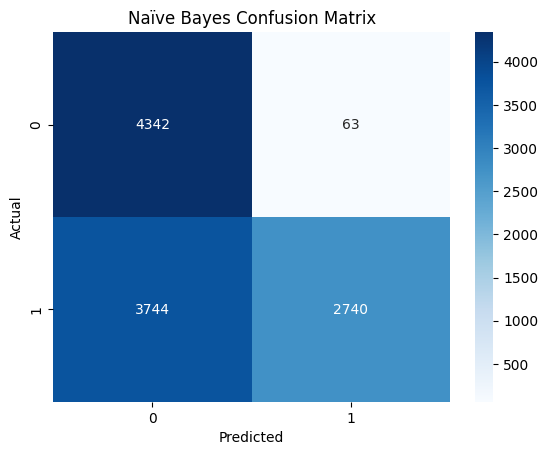

In [29]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)

naive = GaussianNB()

# cross-validation
scores = []
val_labels, val_predictions = [], []
for train_index, val_index in kfold.split(features, labels):
    # Get the training and validation data
    features_train, features_val = features.iloc[train_index], features.iloc[val_index]
    labels_train, labels_val = labels.iloc[train_index], labels.iloc[val_index]

    # Fit the classifier on the training data
    naive.fit(features_train, labels_train)

    # Make predictions on the validation data
    predictions = naive.predict(features_val)
    val_labels.extend(labels_val)
    val_predictions.extend(predictions)

    # Calculate the accuracy of the classifier on the validation data
    score = accuracy_score(labels_val, predictions)
    scores.append(score)
print("Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

# Display the classification report
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

conf_matrix = pd.crosstab(pd.Series(val_labels, name='Actual'), pd.Series(val_predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Naïve Bayes Confusion Matrix")
plt.show()

# NB has no hyperparameters to tune; will just construct for Ensemble

The Naive Bayes model also performed relatively well, with an accuracy of 0.65. This model had very few false positives (with a recall of 0.99 on the 'No' class), but struggled a lot with false negatives. It has a very good precision but low recall. It's f1-score is lower than KNNs. 

# Standard Vector Machine (SVM)

In [22]:
from sklearn import svm

In [18]:
model = svm.SVC()
scaler = StandardScaler()
pca = PCA()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)


pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svm', model)
])

param_grid = {
    'pca__n_components': range(2, 6),
    'svm__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')

predictions = cross_val_predict(grid_search, features, labels, cv=kfold)

SVM Mean Accuracy:  0.6640646524015061
SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.78      0.65      4405
           1       0.80      0.58      0.67      6484

    accuracy                           0.66     10889
   macro avg       0.68      0.68      0.66     10889
weighted avg       0.70      0.66      0.67     10889



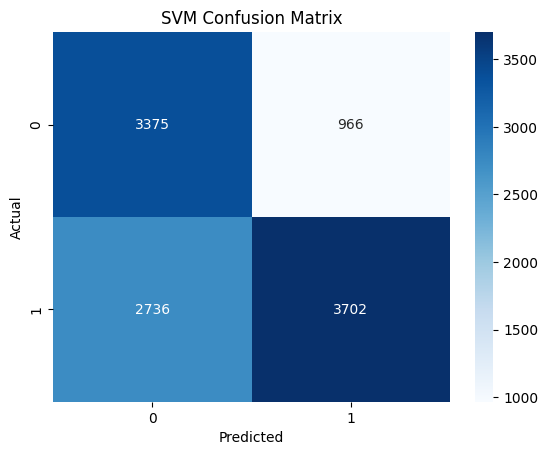

{'pca__n_components': 2, 'svm__kernel': 'rbf'}


In [21]:
accuracy = accuracy_score(labels, predictions)
print("SVM Mean Accuracy: ", accuracy)

print("SVM Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

grid_search.fit(features, labels)
best_params = grid_search.best_params_
print(best_params) #best params to construct SVM with in ensemble 

The SVM had the highest accuracy of all the models so far, with 0.66. The models f1-score is better than Naive Bayes but lower than KNN. It struggled the most with false negatives. The best number of components for dimensionality reduction and the best model kernel are shown above. 

# Neural Network

After attempting to use sklearn's MLPC neural net classifier, we found that the accuracy was poor and sklearn's lack of optimization made the process very long with the size of our dataset. We decided to explore tensorflow and got better, and faster, results.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras_tuner as kt
import tensorflow as tf
import warnings

The function below is used to test hyperparameters on the deep learning sequential neural net. The hyperparameters tested were the number of hidden layers, number of nodes per layer, the activation function, the dropout rate, and the learning rate.

In [3]:
def tf_hyperparam_model(hp):
    model = Sequential()

    # hyperparameter: units per layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    # hyperparameter: number of hidden layers
    hp_num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)

    # hyperparameter: activation function
    hp_activation = hp.Choice('activation_function', values=['relu', 'tanh', 'sigmoid'])

    # hyperparameter: dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.05, max_value=0.5, step=0.05)

    model.add(Input(shape=(6,)))
    for _ in range(hp_num_layers):
        model.add(Dense(units=hp_units, activation=hp_activation))
        model.add(Dropout(hp_dropout))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # hyperparameter: learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
    return model

The function below utilizes the model above to test hyperameters with a training and validation set. To speed this process up, we utilized Tensorflow's Hyperband tuning algorithm, which "uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round." 

This is a much more efficient way to converge on the best hyperparameters, and beats other methods like grid search by miles.

In [14]:
def tf_hyperparam_tester():
    # Split the data into training and validation sets
    features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

    # Scale the training features
    scaler_train = StandardScaler()
    features_train_scaled = scaler_train.fit_transform(features_train)

    # Scale the validation features
    scaler_val = StandardScaler()
    features_val_scaled = scaler_val.fit_transform(features_val)

    tuner = kt.Hyperband(tf_hyperparam_model,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3)

    # search for the best hyperparameters
    tuner.search(features_train_scaled, labels_train, 
                 validation_data=(features_val_scaled, labels_val), 
                 epochs=50, batch_size=64)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps

best_hps = tf_hyperparam_tester()
print("Best hyperparameters:", best_hps.values)


Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.6629935503005981

Best val_accuracy So Far: 0.6795225143432617
Total elapsed time: 00h 05m 06s
Best hyperparameters: {'units': 256, 'num_layers': 4, 'activation_function': 'relu', 'dropout': 0.45, 'learning_rate': 0.01, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Based on the results above, the best performing hyperparameters on the model were 4 hidden layers with 256 nodes per layer, the 'relu' activation function, a dropout rate of 0.45, and a learning rate of 0.01.

We will run cross validation to get a final accuracy score on a model with these hyperparameters.

In [19]:
# build a neural network with the optimal hyperparameters

warnings.filterwarnings('ignore', category=UserWarning)
def tf_model(num_layers, num_units, dropout, activation_fn, learning_rate):
    model = Sequential()

    model.add(Input(shape=(6,)))
    for _ in range(num_layers):
        model.add(Dense(units=num_units, activation=activation_fn))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
    return model

def tf_model_cross_validate(num_layers, num_units, dropout, activation_fn, learning_rate):
    scaler = StandardScaler()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)
    nn = KerasClassifier(model=tf_model(num_layers, num_units, dropout, activation_fn, learning_rate), epochs=100, batch_size=128, verbose=0)
    pipe = Pipeline(steps=[('scaler', scaler), ('nn', nn)])

    predictions = cross_val_predict(pipe, features, labels, cv=kfold)
    return predictions

print("Best hyperparameters found using Hyperband technique:", best_hps.values)
print("Running cross val with best hyperparameters...")
predictions = tf_model_cross_validate(best_hps.values['num_layers'], best_hps.values['units'], best_hps.values['dropout'], best_hps.values['activation_function'], best_hps.values['learning_rate'])

Best hyperparameters found using Hyperband technique: {'units': 256, 'num_layers': 4, 'activation_function': 'relu', 'dropout': 0.45, 'learning_rate': 0.01, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Running cross val with best hyperparameters...


Neural Net Mean Accuracy:  0.6805950959684085
Neural Net Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.97      0.71      4405
           1       0.96      0.48      0.64      6484

    accuracy                           0.68     10889
   macro avg       0.76      0.73      0.68     10889
weighted avg       0.80      0.68      0.67     10889



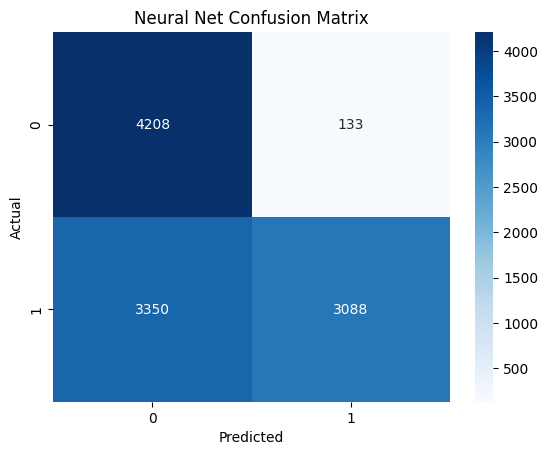

In [20]:
accuracy = accuracy_score(labels, predictions)
print("Neural Net Mean Accuracy: ", accuracy)

print("Neural Net Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Neural Net Confusion Matrix")
plt.show()

After all this work, the resulting accuracy on the neural net is better than any other models with 0.68, but still less than hoped for. It had a very good precision but low recall. The f1-score is also lower than KNN and SVM. However, after doing more research I found that tensorflows neural nets are better suited to tasks such as image classification. Perhaps a different technique suited to tabular data, like XGBoost, would have been a better choice.

# Ensembling the Models

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from scipy.stats import mode


#Different models with best params from earlier found
models = {
    "KNN": KNeighborsClassifier(n_neighbors=12, weights='uniform'),
    "Naive Bayes": GaussianNB(),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('svm', svm.SVC(kernel='rbf'))
    ]),
    "Neural Network": Pipeline([
        ('scaler', StandardScaler()),
        ('nn', KerasClassifier(model=tf_model(best_hps['num_layers'], best_hps['units'], best_hps['dropout'], best_hps['activation_function'], best_hps['learning_rate']), epochs=100, batch_size=128, verbose=0))
    ])
}


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

#list of accuracies of ensemble
overall_accuracies = []

# Loop through each fold
for train_index, val_index in kfold.split(features, labels):
    
    # Split data into train and validation sets for this fold
    features_train, features_val = features.iloc[train_index], features.iloc[val_index]
    labels_train, labels_val = labels.iloc[train_index], labels.iloc[val_index]
    
    #Predictions of each model per fold
    fold_predictions = {model_name: [] for model_name in models}
    #Resepctive accuracies just for debugging
    fold_accuracy = {model_name: [] for model_name in models}
    
    # Train and predict for each model
    for model_name, model in models.items():
        model_clone = None
        if(model_name == "Neural Network"):
            model_clone = Pipeline([
                ('scaler', StandardScaler()),
                ('nn', KerasClassifier(model=tf_model(best_hps['num_layers'], best_hps['units'], best_hps['dropout'], best_hps['activation_function'], best_hps['learning_rate']), epochs=100, batch_size=128, verbose=0))
            ])
        else:
            # Clone the model to ensure independence for each fold
            model_clone = clone(model)

        model_clone.fit(features_train, labels_train)

        predictions = model_clone.predict(features_val)
        
        fold_accuracy[model_name] = accuracy_score(labels_val, predictions)
        fold_predictions[model_name] = predictions
    
    print(fold_accuracy)
    
    # Take majority vote for each data record
    stacked_arrays = np.vstack([value for value in fold_predictions.values()])
    majority_vote_predictions, _ = mode(stacked_arrays, axis=0)

    # Calculate overall accuracy for majority_vote labels
    overall_accuracy = accuracy_score(labels_val, majority_vote_predictions)
    overall_accuracies.append(overall_accuracy)

print("Overall CV accuracy of ensemble: " + str(sum(overall_accuracies) / len(overall_accuracies)))

{'KNN': 0.6597796143250688, 'Naive Bayes': 0.6593204775022957, 'SVM': 0.6707988980716253, 'Neural Network': 0.6781450872359963}
{'KNN': 0.6662075298438935, 'Naive Bayes': 0.647842056932966, 'SVM': 0.669880624426079, 'Neural Network': 0.6831955922865014}
{'KNN': 0.6643709825528007, 'Naive Bayes': 0.6382001836547291, 'SVM': 0.6556473829201102, 'Neural Network': 0.6744719926538109}
{'KNN': 0.6685032139577594, 'Naive Bayes': 0.6542699724517906, 'SVM': 0.6671258034894398, 'Neural Network': 0.6873278236914601}
{'KNN': 0.6646761598530088, 'Naive Bayes': 0.6430868167202572, 'SVM': 0.6655948553054662, 'Neural Network': 0.6816720257234726}
Overall CV accuracy of ensemble: 0.6795848829464731


After ensembling the models and taking a final prediction using weighted voting, we find that the overall accuracy of the ensemble is about 0.68, which is not much of an improvement from any individual model and is about the same as the neural net. This likely indicates that each model is misclassifying the same or similar records, meaning there might be some underlying noise or bias in our dataset as a whole, or that it it is very difficult to predict whether a package reached on time with a confidence of greater than 70% using the features in this dataset. This might be due to insufficient or irrelevant features as well. 

If we were to choose a final model, we would likely go with just the neural net since the ensemble provides similar results to it.